In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os,sys,glob
import cv2
import pickle

from yolo_model.yolo_models import get_yolo_model


/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [28]:

# read image using opencv
image_name =  'dog2.jpg'
im = cv2.imread(image_name)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

# resize image (YOLO needs images with size n*32, m*32 where n,m are integers)
im_height = int(32*round(im.shape[0]/32.0))
im_width = int(32*round(im.shape[1]/32.0))

im = cv2.resize(im,(im_width,im_height))

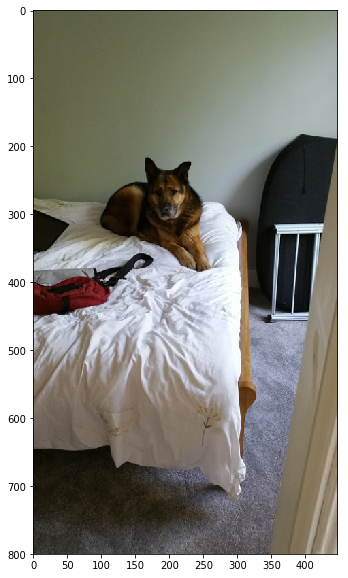

In [30]:
plt.figure(figsize=(10,10))
plt.imshow(im)
plt.show()

In [31]:
yolov3 = get_yolo_model(im_width,im_height,num_class=80)
yolov3.load_weights('weights/yolo-v3-coco.h5')

In [32]:
# rescale image and add in an extra dimension at the start
new_image = im[:,:,::-1]/255.
new_image = np.expand_dims(new_image, 0)

# run the model and get detections
preds = yolov3.predict(new_image)


In [33]:

# code to remove overlapping detections
def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b

    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
             return 0
        else:
            return min(x2,x4) - x3          

def bbox_iou(box1, box2):
    
    intersect_w = _interval_overlap([box1[0], box1[2]], [box2[0], box2[2]])
    intersect_h = _interval_overlap([box1[1], box1[3]], [box2[1], box2[3]])
    
    intersect = intersect_w * intersect_h

    w1, h1 = box1[2]-box1[0], box1[3]-box1[1]
    w2, h2 = box2[2]-box2[0], box2[3]-box2[1]
    
    union = w1*h1 + w2*h2 - intersect
    
    return float(intersect) / union

In [34]:
# this code processes all the detections and removes overlapping objects 
# and objects with a low score

nms_threshold=0.3
obj_threshold=0.5
max_length=10000
new_boxes = np.zeros((0,5))
for i in range(2):
    netout=preds[i][0]
    grid_h, grid_w = netout.shape[:2]
    xpos = netout[...,0]
    ypos = netout[...,1]
    wpos = netout[...,2]
    hpos = netout[...,3]

    objectness = netout[...,4]

    # select only objects above threshold
    indexes = (objectness > obj_threshold) & (wpos<max_length) & (hpos<max_length)
    
    if np.sum(indexes)==0:
        continue

    corner1 = np.column_stack((xpos[indexes]-wpos[indexes]/2.0, ypos[indexes]-hpos[indexes]/2.0))
    corner2 = np.column_stack((xpos[indexes]+wpos[indexes]/2.0, ypos[indexes]+hpos[indexes]/2.0))


    new_boxes = np.append(new_boxes, np.column_stack((corner1, corner2, objectness[indexes])),axis=0)

# do nms 
sorted_indices = np.argsort(-new_boxes[:,4])
boxes=new_boxes.tolist()

for i in range(len(sorted_indices)):

    index_i = sorted_indices[i]

    if new_boxes[index_i,4] == 0: continue

    for j in range(i+1, len(sorted_indices)):
        index_j = sorted_indices[j]
        if bbox_iou(boxes[index_i][0:4], boxes[index_j][0:4]) >= nms_threshold:
            new_boxes[index_j,4] = 0

new_boxes = new_boxes[new_boxes[:,4]>0]

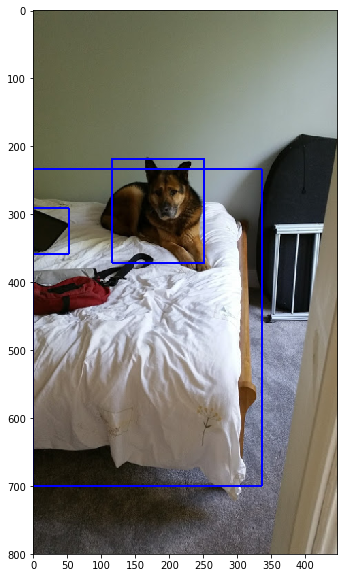

In [35]:

im = cv2.imread(image_name)
im = cv2.resize(im,(im_width,im_height))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

for box in new_boxes:
    xmin  = int((box[0]))
    xmax  = int((box[2]))
    ymin  = int((box[1]))
    ymax  = int((box[3]))
    
    
    cv2.rectangle(im, (xmin,ymin), (xmax,ymax), (0,0,255), 2)
plt.figure(figsize=(10,10))
plt.imshow(im)
cv2.imwrite('test.jpg',im)
plt.show()